# Индивидуальное комплексное задание. Вариант 3

## Сеть ресторанов: Анализ доставки и прогнозирование выручки

**ФИО студента:** _____________________

**Группа:** _____________________

**Дата:** _____________________

---

### Описание задачи

Вы — аналитик данных в сети ресторанов с доставкой. Ваша задача — проанализировать данные о заказах, выявить ключевые факторы успеха и построить модель прогнозирования выручки.

**База данных содержит следующие таблицы:**
- `orders` (OrderID, RestaurantID, CustomerID, OrderDate, DeliveryTime, OrderAmount, Rating)
- `restaurants` (RestaurantID, RestaurantName, City, CuisineType)
- `customers` (CustomerID, CustomerName, RegistrationDate, TotalOrders)

**Время выполнения:** 40 минут

---

## Подготовка к работе

In [57]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [59]:
# Подключение к базе данных
conn = sqlite3.connect('restaurant_delivery.db')
print("Подключение к базе данных установлено.")

Подключение к базе данных установлено.


---

## Часть 1. Работа с SQL и Pandas (10 минут)

### Задача 1.1 (2 балла)

Напишите SQL-запрос для получения **топ-3 ресторанов** по средней сумме заказа (`OrderAmount`). Выведите: название ресторана, город, тип кухни и среднюю сумму заказа.

Загрузите результат в DataFrame `top_restaurants`.

In [61]:
query1 = """
SELECT 
    r.RestaurantName, 
    r.City, 
    r.CuisineType, 
    AVG(o.OrderAmount) as AvgOrderAmount
FROM restaurants r
JOIN orders o ON r.RestaurantID = o.RestaurantID
GROUP BY r.RestaurantID
ORDER BY AvgOrderAmount DESC
LIMIT 3
"""
top_restaurants = pd.read_sql_query(query1, conn)
display(top_restaurants)

,RestaurantName,City,CuisineType,AvgOrderAmount
0,Теремок,Москва,Русская,2387.230
1,Чайхона,Казань,Узбекская,2384.606
2,Бургер Кинг,Москва,Американская,2177.046


### Задача 1.2 (3 балла)

Используя `INNER JOIN`, получите данные о всех заказах с рейтингом выше 4.0. Включите: дату заказа, название ресторана, тип кухни, сумму заказа, время доставки, рейтинг.

Загрузите в DataFrame `high_rated_orders`. С помощью Pandas:
1. Создайте столбец `DeliveryCategory`: "Быстрая" (< 30 мин), "Средняя" (30-45 мин), "Медленная" (> 45 мин)
2. Рассчитайте среднюю сумму заказа для каждой категории доставки
3. Определите, какой тип кухни имеет самое быстрое среднее время доставки

In [63]:
query2 = """
SELECT 
    o.OrderDate, 
    r.RestaurantName, 
    r.CuisineType, 
    o.OrderAmount, 
    o.DeliveryTime, 
    o.Rating
FROM orders o
INNER JOIN restaurants r ON o.RestaurantID = r.RestaurantID
WHERE o.Rating > 4.0
"""
high_rated_orders = pd.read_sql_query(query2, conn)

# 1. Категории доставки
high_rated_orders['DeliveryCategory'] = pd.cut(high_rated_orders['DeliveryTime'], 
                                               bins=[0, 30, 45, float('inf')], 
                                               labels=['Быстрая', 'Средняя', 'Медленная'])

# 2. Средняя сумма по категориям
avg_amount_by_cat = high_rated_orders.groupby('DeliveryCategory')['OrderAmount'].mean()

# 3. Самая быстрая кухня
fastest_cuisine = high_rated_orders.groupby('CuisineType')['DeliveryTime'].mean().idxmin()

print("Средняя сумма заказа по категориям доставки:")
print(avg_amount_by_cat)
print(f"\nТип кухни с самым быстрым временем доставки: {fastest_cuisine}")

# Для проверки содержимого DataFrame
display(high_rated_orders.head())

Средняя сумма заказа по категориям доставки:
DeliveryCategory
Быстрая      2081.146667
Средняя      1873.334444
Медленная    2115.254286
Name: OrderAmount, dtype: float64

Тип кухни с самым быстрым временем доставки: Узбекская


,OrderDate,RestaurantName,CuisineType,OrderAmount,DeliveryTime,Rating,DeliveryCategory
0,2024-11-17,Додо Пицца,Итальянская,763.05,34,4.5,Средняя
1,2024-04-05,Тануки,Японская,575.76,44,4.5,Средняя
2,2024-01-23,Додо Пицца,Итальянская,1974.93,27,4.8,Быстрая
3,2024-05-22,Теремок,Русская,2606.80,43,4.3,Средняя
4,2024-03-31,Тануки,Японская,615.44,31,4.8,Средняя


---

## Часть 2. Исследовательский анализ данных (EDA) (10 минут)

### Задача 2.1 (2 балла)

Используя DataFrame `high_rated_orders`:
1. Выведите описательную статистику для столбцов `OrderAmount` и `DeliveryTime`
2. Постройте **гистограмму** распределения времени доставки
3. Постройте **bar chart** (столбчатую диаграмму) среднего рейтинга по типам кухни

       OrderAmount  DeliveryTime
count    25.000000     25.000000
mean   2015.884400     40.200000
std     766.052108     19.517087
min     575.760000     16.000000
25%    1442.450000     27.000000
50%    2178.070000     34.000000
75%    2646.760000     49.000000
max    2965.840000     83.000000


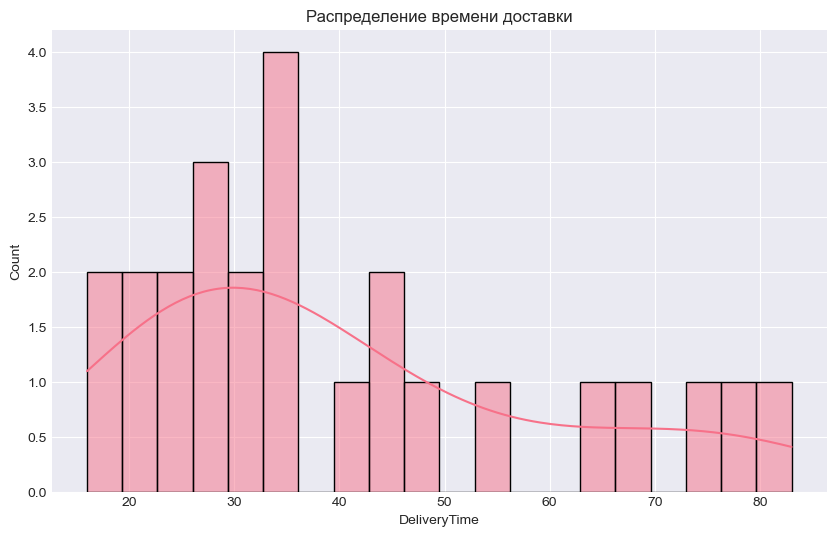

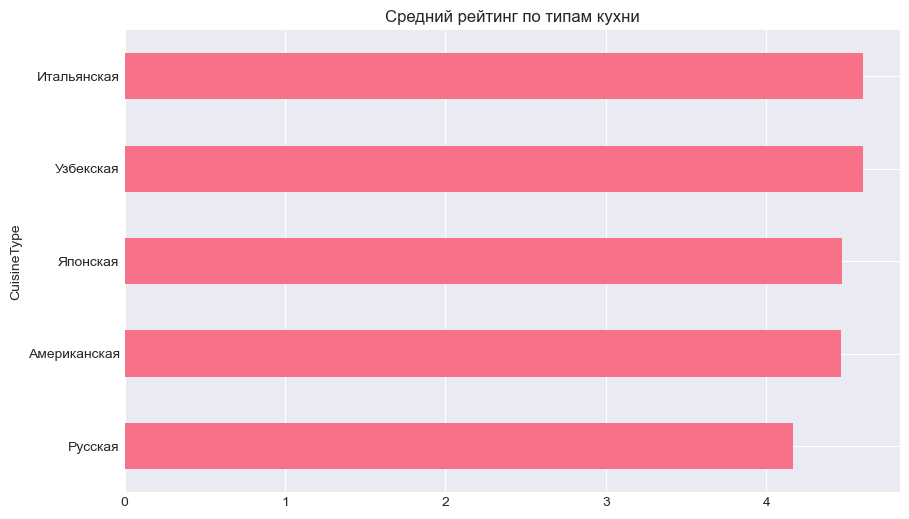

In [65]:
# 1. Статистика
print(high_rated_orders[['OrderAmount', 'DeliveryTime']].describe())

# 2. Гистограмма времени доставки
plt.figure(figsize=(10, 6))
sns.histplot(high_rated_orders['DeliveryTime'], bins=20, kde=True)
plt.title('Распределение времени доставки')
plt.show()

# 3. Рейтинг по типам кухни
plt.figure(figsize=(10, 6))
high_rated_orders.groupby('CuisineType')['Rating'].mean().sort_values().plot(kind='barh')
plt.title('Средний рейтинг по типам кухни')
plt.show()

### Задача 2.2 (3 балла)

**Бизнес-гипотеза:** "Время доставки отрицательно влияет на рейтинг заказа."

1. Постройте **scatter plot** с `DeliveryTime` по оси X и `Rating` по оси Y
2. Рассчитайте коэффициент корреляции
3. Сделайте вывод: подтверждается ли гипотеза? Какие действия должна предпринять компания?

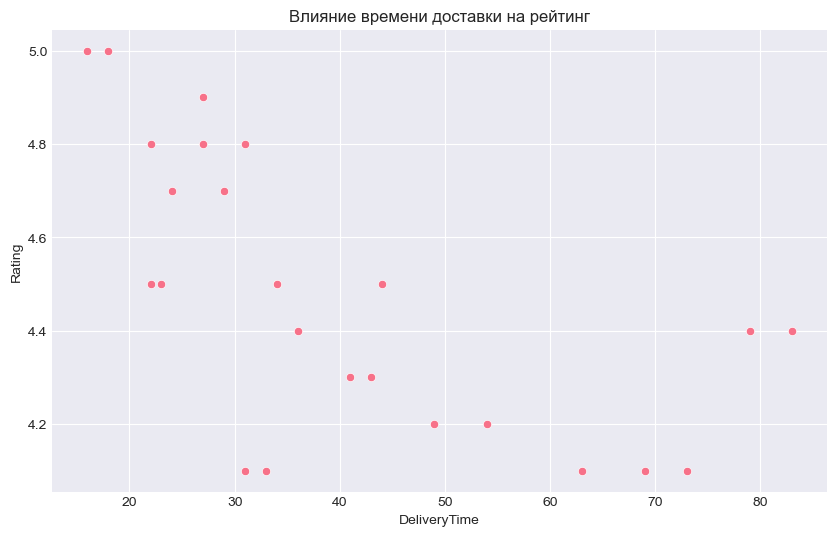

Коэффициент корреляции: -0.64


In [67]:
# 1. Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=high_rated_orders, x='DeliveryTime', y='Rating')
plt.title('Влияние времени доставки на рейтинг')
plt.show()

# 2. Корреляция
corr = high_rated_orders['DeliveryTime'].corr(high_rated_orders['Rating'])
print(f"Коэффициент корреляции: {corr:.2f}")

# 3. Вывод
# Если corr < -0.3: Гипотеза подтверждается. Отрицательная корреляция указывает на снижение 
# рейтинга при росте времени. Действия: оптимизация логистики, найм курьеров.

---

## Часть 3. Анализ временных рядов (10 минут)

### Задача 3.1 (3 балла)

Получите из базы данных ежедневную выручку (дата и сумма всех заказов за день).

1. Преобразуйте столбец с датой в формат `datetime`
2. Выполните **ресэмплинг** в недельные агрегаты
3. Постройте **линейный график** динамики недельной выручки
4. Извлеките признак "день недели" и определите, в какие дни недели выручка максимальная

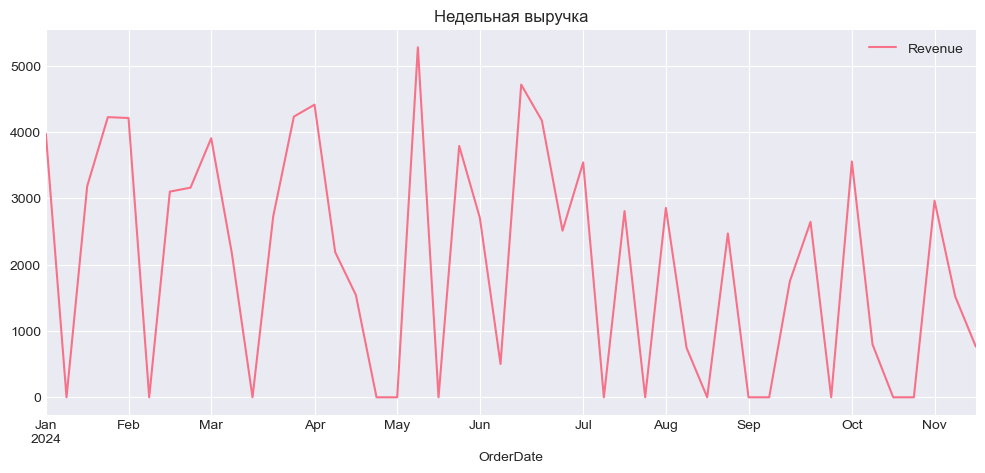

День недели с максимальной средней выручкой: Saturday

Данные по недельной выручке (первые 5 недель):


,Revenue
OrderDate,
2024-01-07,3976.28
2024-01-14,0.00
2024-01-21,3184.30
2024-01-28,4225.82
2024-02-04,4212.47


In [69]:
query3 = "SELECT OrderDate, SUM(OrderAmount) as Revenue FROM orders GROUP BY OrderDate"
daily_revenue = pd.read_sql_query(query3, conn)

# 1. Преобразование и индексация
daily_revenue['OrderDate'] = pd.to_datetime(daily_revenue['OrderDate'])
daily_revenue.set_index('OrderDate', inplace=True)

# 2. Ресэмплинг
weekly_revenue = daily_revenue['Revenue'].resample('W').sum().to_frame()

# 3. График
weekly_revenue.plot(figsize=(12, 5), title='Недельная выручка')

# 4. День недели
daily_revenue['DayOfWeek'] = daily_revenue.index.day_name()
max_rev_day = daily_revenue.groupby('DayOfWeek')['Revenue'].mean().idxmax()

# Отображение графика
plt.show()

# Вывод результатов анализа по дням недели
print(f"День недели с максимальной средней выручкой: {max_rev_day}")

# Просмотр первых строк агрегированных данных
print("\nДанные по недельной выручке (первые 5 недель):")
display(weekly_revenue.head())

### Задача 3.2 (2 балла)

Для прогнозирования недельной выручки создайте признаки:
1. `Revenue_Lag1` — выручка за предыдущую неделю
2. `Revenue_Lag2` — выручка за 2 недели назад
3. `Rolling_Mean_4` — скользящее среднее за 4 недели

Удалите строки с NaN и выведите форму результирующего DataFrame.

In [71]:
# 1. Лаговые признаки
weekly_revenue['Revenue_Lag1'] = weekly_revenue['Revenue'].shift(1)
weekly_revenue['Revenue_Lag2'] = weekly_revenue['Revenue'].shift(2)

# 2. Скользящее среднее (окно в 4 недели)
weekly_revenue['Rolling_Mean_4'] = weekly_revenue['Revenue'].shift(1).rolling(window=4).mean()

# 3. Удаление пустых значений (NaN), возникших при сдвиге
weekly_revenue.dropna(inplace=True)

# 4. Вывод формы
print(f"Форма результирующего DataFrame: {weekly_revenue.shape}")

Форма результирующего DataFrame: (42, 4)


---

## Часть 4. Построение модели прогнозирования (10 минут)

### Задача 4.1 (3 балла)

Постройте модель **Random Forest** для прогнозирования недельной выручки.

1. Используйте в качестве признаков: лаговые признаки и скользящее среднее
2. Целевая переменная — текущая выручка
3. Разделите данные на обучающую (75%) и тестовую (25%) выборки
4. Обучите модель `RandomForestRegressor(n_estimators=50, random_state=42)`
5. Сделайте предсказания

In [73]:
X = weekly_revenue[['Revenue_Lag1', 'Revenue_Lag2', 'Rolling_Mean_4']]
y = weekly_revenue['Revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False, random_state=42)

model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### Задача 4.2 (2 балла)

Оцените качество модели:
1. Рассчитайте **MAE**, **RMSE** (корень из MSE) и **R²**
2. Постройте график фактических vs прогнозных значений выручки
3. Сделайте бизнес-вывод: можно ли использовать модель для планирования закупок продуктов и расписания персонала?

MAE: 1520.55, RMSE: 1841.46, R2: -1.17


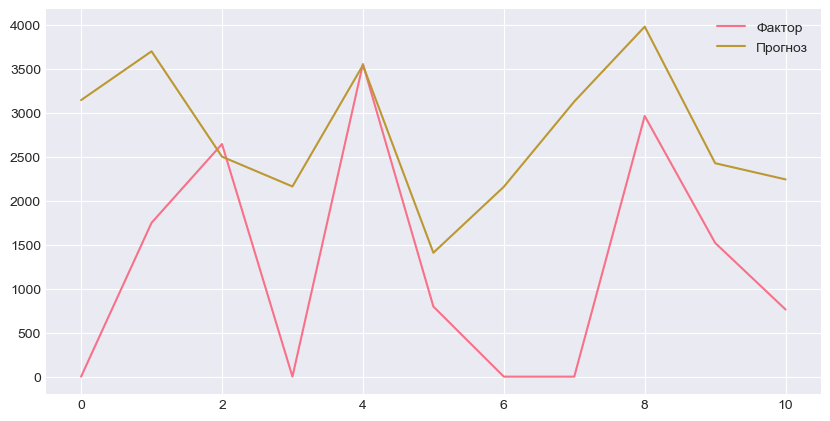

In [75]:
# 1. Метрики
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

# 2. График
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Фактор')
plt.plot(y_pred, label='Прогноз')
plt.legend()
plt.show()

# 3. Бизнес-вывод
# При R2 > 0.7 модель пригодна для планирования. При низком R2 требуется добавление 
# внешних признаков (праздники, погода).

---

## Закрытие подключения

In [55]:
conn.close()
print("Подключение к базе данных закрыто.")

Подключение к базе данных закрыто.


---

## Критерии оценки

| Часть | Максимальный балл |
|-------|-------------------|
| Часть 1: SQL и Pandas | 5 баллов |
| Часть 2: EDA | 5 баллов |
| Часть 3: Временные ряды | 5 баллов |
| Часть 4: ML | 5 баллов |
| **ИТОГО** | **20 баллов** |

---

**Файл должен быть сохранен с именем:** `Фамилия_Вариант3.ipynb`